Michael Haugan <br>
MSDS 422 - Winter 2019 <br>
Assignment 5: Principal Components Analysis <br>

# overview
You will compete in the Kaggle.com Digit Recognizer competition which involves classical digit recognition from hand-written images. https://www.kaggle.com/c/digit-recognizer/ (Links to an external site.)Links to an external site.

Read the competition rules, and download the MNIST training and test set data.This binary classification task is NOT what is required for the current assignment. In this assignment we are asking for a multiclass classifier. The entire MNIST data set will be used for input data. For this assignment, you will develop a classifier that may be used to predict which of the 10 digits is being written.  

(1) Begin by fitting a random forest classifier using the full set of 784 explanatory variables and the model training set (train.csv). Record the time it takes to fit the model and then evaluate the model on the test.csv data by submitting to Kaggle.com. Provide your Kaggle.com score and user ID.

(2) Execute principal components analysis (PCA) on the combined training and test set data together, generating principal components that represent 95 percent of the variability in the explanatory variables. The number of principal components in the solution should be substantially fewer than the 784 explanatory variables. Record the time it takes to identify the principal components.

(3) Using the identified principal components from step (2), use the train.csv to build another random forest classifier. Record the time it takes to fit the model and to evaluate the model on the test.csv data by submitting to Kaggle.com. Provide your Kaggle.com score and user ID.

(4) Submit both the RF Classifier and the PCA RF Classifier to Kaggle.com, and report both scores along with your user name.  I MUST have your user name to verify submission status.

(5) The experiment we have proposed has a MAJOR design flaw. Identify the flaw. Fix it. Rerun the experiment in a way that is consistent with a training-and-test regimen, and submit this to Kaggle.com. Provide your Kaggle.com score and user ID.

# objective
From a management perspective, the predictive accuracy of models must be weighed against the costs of model development and implementation. Suppose you were the manager of a data science team responsible for implementing models for computer vision (classification of images analogous to the MINST problem). Would you recommend using PCA as a preliminary to machine learning classification? Explain your thinking.

# setup

In [237]:
# import packages and set parameters
SET_FIT_INTERCEPT = True
RANDOM_SEED = 1
import numpy as np
from scipy.stats import kurtosis
from scipy.stats import skew
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model 
from time import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, make_scorer  
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from math import sqrt  # for root mean-squared error calculation
# suppress warning messages
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import warnings
warnings.filterwarnings('ignore')

# eda

In [238]:
# read in train and test data
train = pd.read_csv('MNIST_train.csv')
test = pd.read_csv("MNIST_test.csv")

In [239]:
# view train head
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [240]:
# view data types, variables, and sample size for each
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [241]:
# how many of each digit?
train['label'].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [267]:
# create x and y variables
X = train.drop(columns=['label'])
y = pd.DataFrame(train['label'])

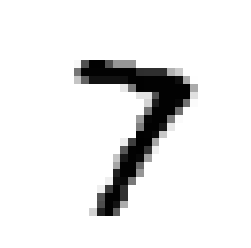

In [243]:
# view one digit
Xarray = X.values
some_digit = Xarray[872]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()

# model building

### 1) random forest classifier

In [214]:
rfc_param_grid = { 
    'max_depth' : [5,10,20],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,3,7]
}

In [215]:
# run GridSearchSV
rfc = RandomForestClassifier(max_features='sqrt', bootstrap=True, n_estimators=10, random_state=23, n_jobs=-1)
CV_rfc = GridSearchCV(estimator=rfc, param_grid=rfc_param_grid, cv=5)
CV_rfc.fit(X, y)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=23, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [5, 10, 20], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 3, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [216]:
# find best params
CV_rfc.best_params_

{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5}

In [217]:
# run rf classifier with optimized params
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_features='sqrt', bootstrap=True, max_depth=20, min_samples_leaf=1,
                        min_samples_split=5, n_estimators=500, random_state=23, n_jobs=-1)

# fit model and record time elapsed
rf_start_time = time()
rfc.fit(X, y)
rf_elapsed_time = time() - rf_start_time
print("Time elapsed: {:.3f}".format(rf_elapsed_time))

# run 5 fold cv
cv_rfc = cross_val_score(rfc, X, y, cv=5, scoring="accuracy")
cv_rfc

Time elapsed: 40.051


array([0.96766524, 0.96527117, 0.96596859, 0.96453225, 0.965     ,
       0.96070493, 0.96522982, 0.96902549, 0.96949476, 0.96663489])

In [218]:
# predict y's from training set
y_train_pred_rf = cross_val_predict(rfc, X, y, cv=5)

In [219]:
# create confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y, y_train_pred_rf)

array([[4070,    0,    4,    2,    5,    6,   17,    1,   25,    2],
       [   0, 4610,   24,   13,    7,    3,    8,    8,    7,    4],
       [  14,   10, 4035,   26,   17,    2,   11,   34,   23,    5],
       [   7,    6,   59, 4127,    2,   46,    9,   28,   42,   25],
       [   5,    6,    6,    0, 3953,    0,   19,    5,   10,   68],
       [  14,    6,    6,   50,    4, 3643,   28,    3,   21,   20],
       [  18,    6,    2,    0,    9,   24, 4064,    0,   14,    0],
       [   3,   19,   48,    6,   19,    1,    0, 4234,    9,   62],
       [   7,   22,   20,   38,   17,   24,   13,    3, 3875,   44],
       [  21,   11,    8,   56,   53,    9,    2,   39,   30, 3959]])

In [220]:
# compute f1 score
from sklearn.metrics import f1_score
f1_score(y, y_train_pred_rf, average="macro")

0.9657792654065614

In [221]:
# run model on test data
y_test_pred_rf = rfc.predict(test)

In [222]:
# create dataframe with test digit predictions
rf_predicted_digits = pd.DataFrame()
rf_predicted_digits['ImageID'] = pd.Series(range(1,28001))
rf_predicted_digits['Label'] = rfc.predict(test)

In [223]:
# view head
rf_predicted_digits.head()

,ImageID,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [224]:
# write to csv
rf_predicted_digits.to_csv("MNIST_Submission_rf2.csv", encoding='utf-8', index=False)

In [225]:
# kaggle score
# userid: michaelhaugan
# score: 0.96585

### 2) PCA

In [226]:
# combine training and test set
combinedDf = pd.concat([train, test])
combinedDf.shape

(70000, 785)

In [276]:
# create x and y variables
X_pca = combinedDf.drop(columns=['label'])
y_pca = pd.DataFrame(combinedDf['label'])

In [280]:
# run PCA
PCA_start_time = time()

pca = PCA(n_components=0.95, random_state=23)
pca.fit(X_pca)

PCA_elapsed_time = time() - PCA_start_time
print("Time elapsed: {:.3f}".format(PCA_elapsed_time))
print("Number of principal components:", pca.n_components_)

Time elapsed: 6.546
Number of principal components: 154


### 3) PCA with random forest classifier

In [281]:
# run PCA on train and test with 154 components
X_train_reduced = pca.transform(X)
X_test_reduced = pca.transform(test)

In [282]:
# set up gridsearch params
rfc_pca_param_grid = { 
    'max_depth' : [5,10,20],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,3,7]
}

In [283]:
# run GridSearchSV
start_time = time()

rfc_pca = RandomForestClassifier(max_features='sqrt', bootstrap=True, n_estimators=10, random_state=23, n_jobs=-1)
CV_rfc_pca = GridSearchCV(estimator=rfc_pca, param_grid=rfc_pca_param_grid, cv=5)
CV_rfc_pca.fit(X_train_reduced, y)

elapsed_time = time() - start_time

In [284]:
# find best params
CV_rfc_pca.best_params_

{'max_depth': 20, 'min_samples_leaf': 3, 'min_samples_split': 10}

In [285]:
# run rf classifier with PCA and optimized params
rfc_pca = RandomForestClassifier(max_features='sqrt', bootstrap=True, max_depth=20, min_samples_leaf=3,
                        min_samples_split=10, n_estimators=500, random_state=23, n_jobs=-1)

# fit model and record time elapsed
rf_pca_start_time = time()
rfc_pca.fit(X_train_reduced, y)
rf_pca_elapsed_time = time() - rf_pca_start_time
print("Time elapsed: {:.3f}".format(rf_pca_elapsed_time))

# run 5 fold cv
cv_rfc_pca = cross_val_score(rfc_pca, X_train_reduced, y, cv=5, scoring="accuracy")
cv_rfc_pca

Time elapsed: 93.000


In [286]:
# predict y's from training set
y_train_pred_rf_pca = cross_val_predict(rfc_pca, X_train_reduced, y, cv=5)

In [287]:
# create confusion matrix
confusion_matrix(y, y_train_pred_rf_pca)

array([[4026,    2,    5,    4,    8,    8,   36,    3,   38,    2],
       [   0, 4533,   39,    3,    9,    8,    9,    8,   65,   10],
       [  22,   16, 3906,   35,   57,    4,   31,   61,   34,   11],
       [  18,   13,  106, 3831,    8,  121,    7,   61,  136,   50],
       [   6,    9,   14,    0, 3825,    4,   52,   12,   12,  138],
       [  13,    6,   12,  223,   35, 3330,   48,    7,   87,   34],
       [  28,   11,    7,    0,   20,   29, 4015,   10,   17,    0],
       [   5,   18,   45,    3,   58,    3,    1, 4135,   22,  111],
       [  14,   70,   54,  153,   30,  113,   33,   22, 3505,   69],
       [  21,   11,    6,   65,  159,   14,   12,   81,   52, 3767]])

In [288]:
# compute f1 score
f1_score(y, y_train_pred_rf_pca, average="macro")

0.924627270284238

In [289]:
# run rf pca model on test data
y_test_pred_rf_pca = rfc_pca.predict(X_test_reduced)

In [290]:
# create dataframe with test digit predictions
rf_pca_predicted_digits = pd.DataFrame()
rf_pca_predicted_digits['ImageID'] = pd.Series(range(1,28001))
rf_pca_predicted_digits['Label'] = y_test_pred_rf_pca

In [291]:
# view head
rf_pca_predicted_digits.head()

,ImageID,Label
0,1,2
1,2,0
2,3,9
3,4,7
4,5,3


In [292]:
# write to csv
rf_pca_predicted_digits.to_csv("MNIST_Submission_rf_pca2.csv", encoding='utf-8', index=False)

In [256]:
# kaggle score
# userid: michaelhaugan
# score: 0.92114

### 4) kaggle scores

Rf classifer <br>
Username: michaelhaugan <br>
score: 0.96585 <br>

Rf classifier with PCA <br>
Username: michaelhaugan <br>
score: 0.92114

### 5) Design flaw - rerun with flaw fixed

The design flaw in my mind is the fact that you had us run PCA after combining both the test and control datasets together. I think we should run PCA separately on each.

In [293]:
# fit PCA on training set
PCA_start_time = time()

pca2 = PCA(n_components=0.95)
pca2.fit(X)

PCA_elapsed_time = time() - PCA_start_time
print("Time elapsed: {:.3f}".format(PCA_elapsed_time))
print("Number of principal components:", pca2.n_components_)

Time elapsed: 4.007
Number of principal components: 154


In [294]:
# transform PCA from above onto train and test
X_train_reduced2 = pca2.transform(X)
X_test_reduced2 = pca2.transform(test)

In [295]:
# set up gridsearch params
rfc_pca_param_grid2 = { 
    'max_depth' : [5,10,20],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,3,7]
}

In [296]:
# run GridSearchSV
start_time = time()

rfc_pca2 = RandomForestClassifier(max_features='sqrt', bootstrap=True, n_estimators=10, random_state=23, n_jobs=-1)
CV_rfc_pca2 = GridSearchCV(estimator=rfc_pca2, param_grid=rfc_pca_param_grid2, cv=5)
CV_rfc_pca2.fit(X_train_reduced2, y)

elapsed_time = time() - start_time

In [297]:
# find best params
CV_rfc_pca2.best_params_

{'max_depth': 20, 'min_samples_leaf': 3, 'min_samples_split': 10}

In [298]:
# run rf classifier with PCA and optimized params
rfc_pca2 = RandomForestClassifier(max_features='sqrt', bootstrap=True, max_depth=20, min_samples_leaf=3,
                        min_samples_split=10, n_estimators=500, random_state=23, n_jobs=-1)

# fit model and record time elapsed
rf_pca_start_time = time()
rfc_pca2.fit(X_train_reduced2, y)
rf_pca_elapsed_time = time() - rf_pca_start_time
print("Time elapsed: {:.3f}".format(rf_pca_elapsed_time))

# run 5 fold cv
cv_rfc_pca2 = cross_val_score(rfc_pca2, X_train_reduced2, y, cv=5, scoring="accuracy")
cv_rfc_pca2

Time elapsed: 89.992


array([0.94039262, 0.94097346, 0.93618288, 0.93902584, 0.94652215])

In [300]:
# predict y's from training set
y_train_pred_rf_pca2 = cross_val_predict(rfc_pca2, X_train_reduced2, y, cv=5)

In [301]:
# create confusion matrix
confusion_matrix(y, y_train_pred_rf_pca2)

array([[4026,    0,   12,   13,    5,    9,   39,    3,   23,    2],
       [   0, 4579,   32,   20,    2,    8,   10,    7,   23,    3],
       [  23,   13, 3886,   53,   45,    5,   13,   43,   88,    8],
       [  11,    5,   67, 4019,    2,   71,   21,   39,   84,   32],
       [   4,   19,   27,    4, 3841,    4,   29,   11,   27,  106],
       [  24,    1,   13,  109,   29, 3512,   48,    4,   23,   32],
       [  35,    4,   13,    1,   11,   46, 4022,    0,    5,    0],
       [  12,   32,   57,    8,   34,    3,    3, 4152,   16,   84],
       [  12,   28,   32,  136,   22,   88,   18,   16, 3658,   53],
       [  25,    9,   16,   78,  108,   16,    4,   83,   38, 3811]])

In [302]:
# compute f1 score
f1_score(y, y_train_pred_rf_pca2, average="macro")

0.9400624824859884

In [303]:
# run rf pca model on test data
y_test_pred_rf_pca2 = rfc_pca2.predict(X_test_reduced2)

In [304]:
# create dataframe with test digit predictions
rf_pca_predicted_digits2 = pd.DataFrame()
rf_pca_predicted_digits2['ImageID'] = pd.Series(range(1,28001))
rf_pca_predicted_digits2['Label'] = y_test_pred_rf_pca2

In [305]:
# view head
rf_pca_predicted_digits2.head()

,ImageID,Label
0,1,2
1,2,0
2,3,9
3,4,4
4,5,3


In [306]:
# write to csv
rf_pca_predicted_digits2.to_csv("MNIST_Submission_rf_pca3.csv", encoding='utf-8', index=False)

In [307]:
# kaggle score
# userid: michaelhaugan
# score: 0.94400